In [1]:
import pandas as pd
import numpy as np
#imports
import warnings
warnings.filterwarnings("ignore")


In [2]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('c:\\Users\\caperei\\portuguese_open_data\\code\\deployment')
import polarization_parliament.utils.data_utils as dtu
import polarization_parliament.nlp.nlp_function as nlpf
import polarization_parliament.polarization_model.polarized_terms as polr

In [3]:
def get_table_polarized_terms_by_leg(file_leg): #"speech_selected_13.csv"
    declaracoes2=dtu.read_pre_text(file_leg)
    names_deputies, parties_=dtu.load_deputies_names('deputies_2015_now.csv')
    dates_df=dtu.load_data_legis('datas_leg.csv')
    declaracoes2=dtu.clean_partiesnames(declaracoes2)


    declaracoes2=nlpf.remove_punctuation(declaracoes2)
    declaracoes2=nlpf.remove_names_in_speech(declaracoes2,names_deputies,parties_)
    declaracoes2=nlpf.create_tokens(declaracoes2)
    declaracoes2=nlpf.create_grams(declaracoes2, 3)

    declaracoes2=dtu.add_dates_main(declaracoes2, dates_df)
    declaracoes2=dtu.extract_president_names(declaracoes2)

    declaracoes3=polr.apply_polarization_model(declaracoes2)
    df_final200=nlpf.create_200r(declaracoes3)
    df_final200=nlpf.add_url_finaldf(df_final200,declaracoes2)

    return declaracoes3, df_final200


def get_table_shared_terms_by_leg(file_leg): #"speech_selected_13.csv"
    declaracoes2=dtu.read_pre_text(file_leg)
    names_deputies, parties_=dtu.load_deputies_names('deputies_2015_now.csv')
    dates_df=dtu.load_data_legis('datas_leg.csv')
    declaracoes2=dtu.clean_partiesnames(declaracoes2)


    declaracoes2=nlpf.remove_punctuation(declaracoes2)
    declaracoes2=nlpf.remove_names_in_speech(declaracoes2,names_deputies,parties_)
    declaracoes2=nlpf.create_tokens(declaracoes2)
    declaracoes2=nlpf.create_grams(declaracoes2, 3)

    declaracoes2=dtu.add_dates_main(declaracoes2, dates_df)
    declaracoes2=dtu.extract_president_names(declaracoes2)

    declaracoes3=polr.apply_shared_issues(declaracoes2)
    
    
    return declaracoes3, declaracoes2

def get_minimal_count(n, name_file):
    dates_df=dtu.load_data_legis(name_file) #'datas_leg.csv'
    dates_df=dates_df[dates_df.legislatura==n]
    dd=dates_df.groupby(['legislatura','session','number']).number.nunique()
    dff=pd.DataFrame(pd.DataFrame(dd).groupby(['legislatura','session']).number.sum())
    out_=dff.number.sum()
    return int(0.1*out_)


In [8]:
declaracoes13, df_final_13_200= get_table_polarized_terms_by_leg('speech_selected_13.csv')
df_final_13_200.to_excel("output/polarized200_leg13.xlsx")  

declaracoes14, df_final_14_200= get_table_polarized_terms_by_leg('speech_selected_14.csv')
df_final_14_200.to_excel("output/polarized200_leg14.xlsx")  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
l13_cn=get_minimal_count(13, 'datas_leg.csv')
l14_cn=get_minimal_count(14, 'datas_leg.csv')

In [5]:
dates_df=dtu.load_data_legis('datas_leg.csv') #'datas_leg.csv'
dates_df['date']=pd.to_datetime(dates_df['date'], format='%d/%m/%Y')
print('Leg 13 inicio e fim:\n',dates_df[dates_df.legislatura==13].date.min(), dates_df[dates_df.legislatura==13].date.max())
print('number of discourses:',l13_cn*10)

print('\nLeg 14 inicio e fim:\n',dates_df[dates_df.legislatura==13].date.min(), dates_df[dates_df.legislatura==13].date.max())
print('number of discourses:',l14_cn*10)

Leg 13 inicio e fim:
 2015-10-23 00:00:00 2019-10-09 00:00:00
number of discourses: 410

Leg 14 inicio e fim:
 2015-10-23 00:00:00 2019-10-09 00:00:00
number of discourses: 200


In [6]:
df_shared_13, df_url_13=get_table_shared_terms_by_leg("speech_selected_13.csv") #"speech_selected_13.csv"
df_shared_14, df_url_14=get_table_shared_terms_by_leg("speech_selected_14.csv") #"speech_selected_13.csv"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.25     99.0
0.50    123.0
0.75    179.0
Name: count, dtype: float64

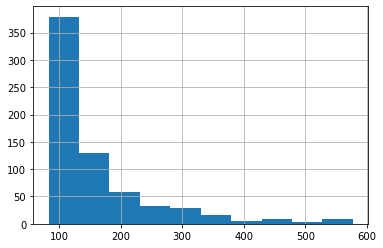

In [7]:
#Selection first on number of times the words are spoken

#count of trigrams bigger than 20% of the number of sessions (total of 410 sessions in leg13)
#spoken at least in 20% of the sessions
#df_shared_13[df_shared_13['count']>82]['count'].hist()
#clipping outliers visually fetch from historgram
#remove highly spoken works
df_shared_13[(df_shared_13['count']>82) & (df_shared_13['count']<600)]['count'].hist()

df_shared_13[(df_shared_13['count']>82) & (df_shared_13['count']<600)]['count'].quantile([0.25,0.5,0.75])

#conclusion: selection between Q1 and Q3: 96<count<134

0.25   -0.000010
0.50   -0.000002
0.75    0.000005
Name: gram_partisanship, dtype: float64

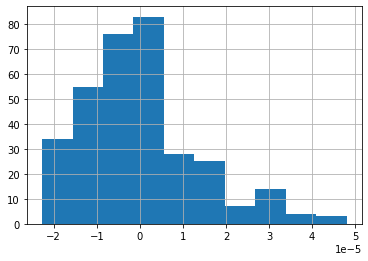

In [8]:
#Selection from the partisanship

#count of trigrams bigger than 20% of the number of sessions (total of 410 sessions in leg13)
#spoken at least in 20% of the sessions
#declaracoes13[declaracoes13['count']>82]['count'].hist()
#clipping outliers visually fetch from historgram
#remove highly spoken works
df_shared_13[(df_shared_13['count']>99) & (df_shared_13['count']<179)]['gram_partisanship'].hist()

df_shared_13[(df_shared_13['count']>99) & (df_shared_13['count']<179)]['gram_partisanship'].quantile([0.25,0.5,0.75])

#conclusion: selection between Q1 and Q3: 96<count<134

In [9]:
df_shared_13_final=df_shared_13[(df_shared_13['count']>99) & (df_shared_13['count']<179)& (df_shared_13['gram_partisanship']>-0.000010) & (df_shared_13['gram_partisanship']<0.000005)]

df_finalshared=nlpf.add_url_finaldf(df_shared_13_final,df_url_13)
df_finalshared.to_excel("output/df_shared_13_final.xlsx")  

In [32]:
import datetime
tri_final=df_shared_13_final
tri_final['reference'] = [[]] * tri_final.shape[0]
tri_final=tri_final.reset_index()
for n,x in enumerate(tri_final.phrase):
    
    a=[i.count(x) for i in df_url_13.tri_grams]
    indexes=np.where(np.array(a) >= 3)[0]
    list_links=[]
    for i in indexes:
        number=nlpf.add_zeros(df_url_13.iloc[i].number ) 
        legislature=df_url_13.iloc[i].legislatura 
        session=df_url_13.iloc[i].session 
        date=datetime.datetime.strptime(df_url_13.iloc[i].date , '%d/%m/%Y').strftime('%Y-%m-%d')
        url_=f'https://debates.parlamento.pt/catalogo/r3/dar/01/{legislature}/{session}/{number}/{date}' 
        list_links.append(url_)
        #print(n, list_links)
    if list_links==[]:
        list_links=['does not appear more than 3 times']
    
    tri_final['reference'][n]=list_links

KeyboardInterrupt: 

In [ ]:
#14

In [18]:
df_shared_14=get_table_shared_terms_by_leg("speech_selected_14.csv") #"speech_selected_13.csv"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.25    48.0
0.50    62.0
0.75    95.0
Name: count, dtype: float64

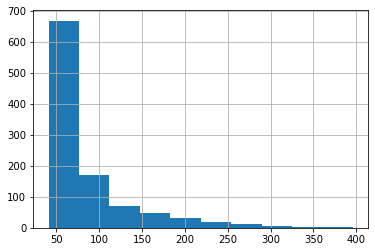

In [22]:
#Selection first on number of times the words are spoken

#count of trigrams bigger than 20% of the number of sessions (total of 200 sessions in leg14)
#spoken at least in 20% of the sessions
#df_shared_14[df_shared_14['count']>40]['count'].hist()
#clipping outliers visually fetch from historgram
#remove highly spoken works
df_shared_14[(df_shared_14['count']>40) & (df_shared_14['count']<400)]['count'].hist()

df_shared_14[(df_shared_14['count']>40) & (df_shared_14['count']<400)]['count'].quantile([0.25,0.5,0.75])

#conclusion: selection between Q1 and Q3: 96<count<134

0.25   -0.000007
0.50   -0.000002
0.75    0.000004
Name: gram_partisanship, dtype: float64

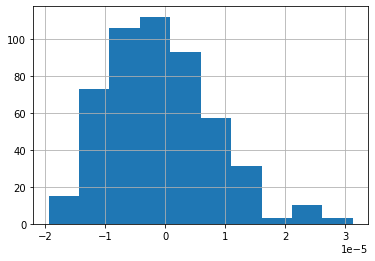

In [25]:
#Selection from the partisanship

#count of trigrams bigger than 20% of the number of sessions (total of 410 sessions in leg13)
#spoken at least in 20% of the sessions
#declaracoes13[declaracoes13['count']>82]['count'].hist()
#clipping outliers visually fetch from historgram
#remove highly spoken works
df_shared_14[(df_shared_14['count']>48) & (df_shared_14['count']<95)]['gram_partisanship'].hist()

df_shared_14[(df_shared_14['count']>48) & (df_shared_14['count']<95)]['gram_partisanship'].quantile([0.25,0.5,0.75])

#conclusion: selection between Q1 and Q3: 96<count<134

In [26]:
df_shared_14_final=df_shared_14[(df_shared_14['count']>48) & (df_shared_14['count']<95)& (df_shared_14['gram_partisanship']>-0.000007) & (df_shared_14['gram_partisanship']<0.000004)]


df_finalshared14=nlpf.add_url_finaldf(df_shared_14_final,df_url_14)
df_finalshared14.to_excel("output/df_shared_14_final.xlsx")  


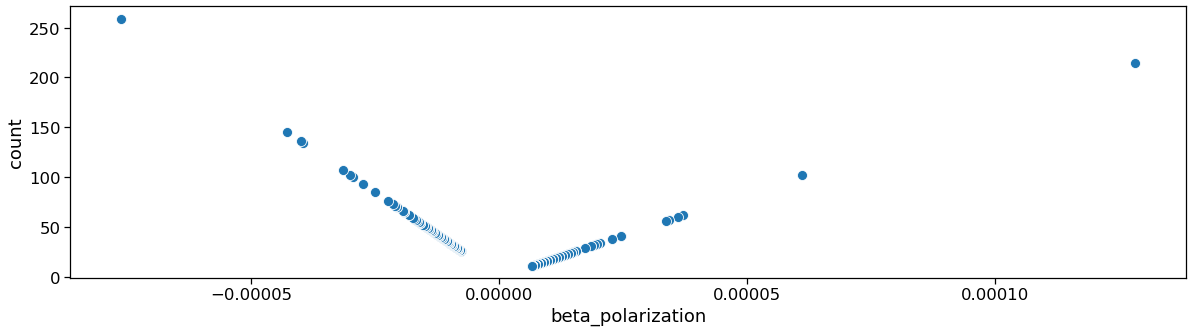

In [5]:
plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="beta_polarization",y='count',s=100,
                data=df_final200)

In [ ]:
#create link
discutidos_final['reference'] = [[]] * discutidos_final.shape[0]
for n,x in enumerate(discutidos_final.phrase):
    a=[i.count(x) for i in declaracoes2.tri_grams]
    indexes=np.where(np.array(a) >= 3)[0]
    list_links=[]
    for i in indexes:
        number=add_zeros(declaracoes2.iloc[i].number ) 
        legislature=declaracoes2.iloc[i].legislatura 
        session=declaracoes2.iloc[i].session 
        date=datetime.datetime.strptime(declaracoes2.iloc[i].date , '%d/%m/%Y').strftime('%Y-%m-%d')
        url_=f'https://debates.parlamento.pt/catalogo/r3/dar/01/{legislature}/{session}/{number}/{date}' 
        list_links.append(url_)
    if list_links==[]:
        list_links=['does not appear more than 3 times']

    discutidos_final.iloc[n, discutidos_final.columns.get_loc('reference')].append(list(set(list_links)))

In [ ]:
discutidos_final.to_csv('temas_discutidos.csv')